In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/restaurant-revenue-prediction-dataset/restaurant_data.csv


In [2]:
import numpy as np 
import pandas as pd
df = pd.read_csv("/kaggle/input/restaurant-revenue-prediction-dataset/restaurant_data.csv")
df.head()


,Name,Location,Cuisine,Rating,Seating Capacity,Average Meal Price,Marketing Budget,Social Media Followers,Chef Experience Years,Number of Reviews,Avg Review Length,Ambience Score,Service Quality Score,Parking Availability,Weekend Reservations,Weekday Reservations,Revenue
0,Restaurant 0,Rural,Japanese,4.0,38,73.98,2224,23406,13,185,161.924906,1.3,7.0,Yes,13,4,638945.52
1,Restaurant 1,Downtown,Mexican,3.2,76,28.11,4416,42741,8,533,148.759717,2.6,3.4,Yes,48,6,490207.83
2,Restaurant 2,Rural,Italian,4.7,48,48.29,2796,37285,18,853,56.849189,5.3,6.7,No,27,14,541368.62
3,Restaurant 3,Rural,Italian,4.4,34,51.55,1167,15214,13,82,205.433265,4.6,2.8,Yes,9,17,404556.80
4,Restaurant 4,Downtown,Japanese,4.9,88,75.98,3639,40171,9,78,241.681584,8.6,2.1,No,37,26,1491046.35


In [3]:
from sklearn.preprocessing import LabelEncoder

#  Eksik değer kontrolü
print("📌 Eksik Değer Sayıları:")
print(df.isnull().sum())

# Kategorik sütunları Label Encode edelim 
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))

# Veri setinin son hali
df.head()



📌 Eksik Değer Sayıları:
Name                      0
Location                  0
Cuisine                   0
Rating                    0
Seating Capacity          0
Average Meal Price        0
Marketing Budget          0
Social Media Followers    0
Chef Experience Years     0
Number of Reviews         0
Avg Review Length         0
Ambience Score            0
Service Quality Score     0
Parking Availability      0
Weekend Reservations      0
Weekday Reservations      0
Revenue                   0
dtype: int64


,Name,Location,Cuisine,Rating,Seating Capacity,Average Meal Price,Marketing Budget,Social Media Followers,Chef Experience Years,Number of Reviews,Avg Review Length,Ambience Score,Service Quality Score,Parking Availability,Weekend Reservations,Weekday Reservations,Revenue
0,0,1,4,4.0,38,73.98,2224,23406,13,185,161.924906,1.3,7.0,1,13,4,638945.52
1,1,0,5,3.2,76,28.11,4416,42741,8,533,148.759717,2.6,3.4,1,48,6,490207.83
2,1112,1,3,4.7,48,48.29,2796,37285,18,853,56.849189,5.3,6.7,0,27,14,541368.62
3,2223,1,3,4.4,34,51.55,1167,15214,13,82,205.433265,4.6,2.8,1,9,17,404556.80
4,3334,0,4,4.9,88,75.98,3639,40171,9,78,241.681584,8.6,2.1,0,37,26,1491046.35


In [4]:
pip install deap


Note: you may need to restart the kernel to use updated packages.


In [5]:
import random
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from deap import base, creator, tools, algorithms

# Veri ayrımı ve ölçekleme
X = df.drop(columns=['Revenue']).values
y = df['Revenue'].values
feature_names = df.drop(columns=['Revenue']).columns.tolist()

X_scaled = StandardScaler().fit_transform(X)
n_feat = X.shape[1]
K = 10  # Seçilecek özellik sayısı
RND = 42
random.seed(RND)

# DEAP konfigürasyonu
if "FitnessMax" not in creator.__dict__:
    creator.create("FitnessMax", base.Fitness, weights=(1.0,))
if "Individual" not in creator.__dict__:
    creator.create("Individual", list, fitness=creator.FitnessMax)

def repair(ind):
    ones = sum(ind)
    if ones > K:
        for i in random.sample([i for i, b in enumerate(ind) if b], ones - K):
            ind[i] = 0
    elif ones < K:
        for i in random.sample([i for i, b in enumerate(ind) if not b], K - ones):
            ind[i] = 1

def gen_individual():
    ind = [0] * n_feat
    for i in random.sample(range(n_feat), K):
        ind[i] = 1
    return creator.Individual(ind)

def eval_feat(ind):
    sel = [i for i, b in enumerate(ind) if b]
    model = RandomForestRegressor(n_estimators=30, random_state=RND, n_jobs=-1)
    score = cross_val_score(model, X_scaled[:, sel], y, cv=3, scoring='r2', n_jobs=-1).mean()
    return score,

def mate_and_repair(ind1, ind2):
    tools.cxTwoPoint(ind1, ind2)
    repair(ind1)
    repair(ind2)
    return ind1, ind2

def mutate_and_repair(ind, indpb):
    tools.mutFlipBit(ind, indpb)
    repair(ind)
    return ind,

# GA toolbox
toolbox = base.Toolbox()
toolbox.register("individual", gen_individual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", eval_feat)
toolbox.register("mate", mate_and_repair)
toolbox.register("mutate", mutate_and_repair, indpb=0.1)
toolbox.register("select", tools.selTournament, tournsize=3)

# GA çalıştır
pop = toolbox.population(n=30)
hof = tools.HallOfFame(1)
algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=20, halloffame=hof, verbose=True)

# Seçilen özellikler
best = hof[0]
selected_idx = [i for i, b in enumerate(best) if b]
selected_features = [feature_names[i] for i in selected_idx]

print(f"\nSeçilen {len(selected_features)} özellik:")
for feat in selected_features:
    print("-", feat)


gen	nevals
0  	30    
1  	12    
2  	19    
3  	22    
4  	11    
5  	15    
6  	19    
7  	17    
8  	20    
9  	10    
10 	25    
11 	15    
12 	20    
13 	22    
14 	17    
15 	17    
16 	18    
17 	16    
18 	18    
19 	14    
20 	19    

Seçilen 10 özellik:
- Location
- Cuisine
- Rating
- Seating Capacity
- Average Meal Price
- Marketing Budget
- Social Media Followers
- Chef Experience Years
- Service Quality Score
- Parking Availability


In [6]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np

# Giriş ve hedef
X = df[selected_features].values
y = df['Revenue'].values  # hedef sütun

# Ölçekleme
X_scaled = StandardScaler().fit_transform(X)

# PCA (10 bileşen)
pca = PCA(n_components=10, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# PCA çıktısı kontrol
print(f"\nPCA sonrası boyut: {X_pca.shape[1]} bileşen")
for i, var in enumerate(pca.explained_variance_ratio_, 1):
    print(f"  PC{i}: {var:.3f}")



PCA sonrası boyut: 10 bileşen
  PC1: 0.285
  PC2: 0.108
  PC3: 0.104
  PC4: 0.102
  PC5: 0.100
  PC6: 0.098
  PC7: 0.095
  PC8: 0.055
  PC9: 0.051
  PC10: 0.001


                      R2          MAE           MSE         RMSE    MAPE
Model                                                                   
LinearRegression  0.9578   41626.1512  3.010172e+09   54851.5882  0.0785
Ridge             0.9578   41624.1808  3.010169e+09   54851.5504  0.0785
Lasso             0.9578   41626.1305  3.010173e+09   54851.5886  0.0785
ElasticNet        0.9551   41947.7967  3.204866e+09   56591.8482  0.0715
HuberRegressor    0.9572   41292.4302  3.057115e+09   55272.8371  0.0752
SVR_RBF          -0.0374  211421.2793  7.407365e+10  272064.0039  0.3558
RandomForest      0.9665   36255.7091  2.387780e+09   48834.0069  0.0593
GradientBoosting  0.9634   38564.3092  2.609784e+09   51061.1103  0.0618


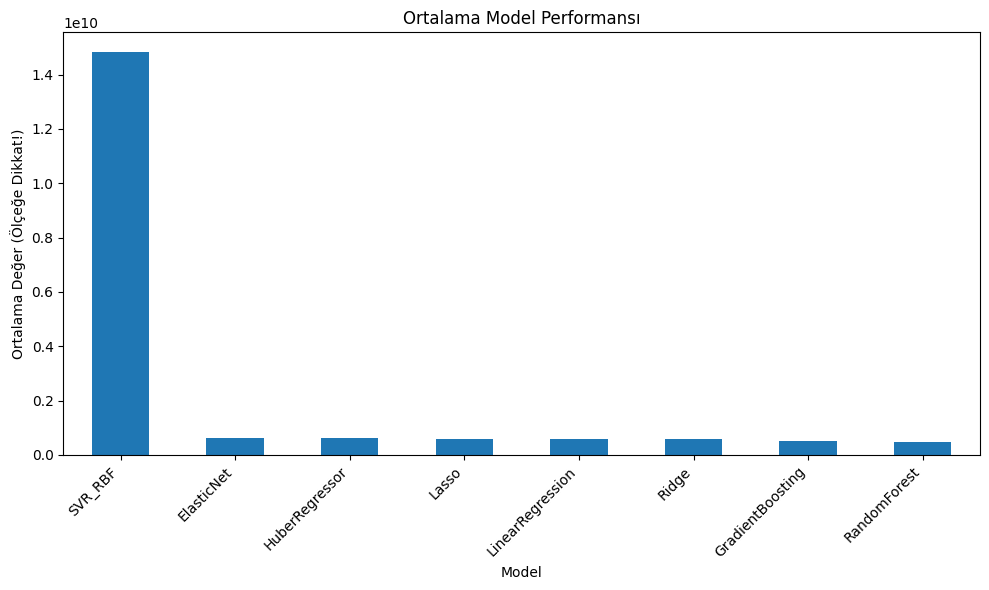

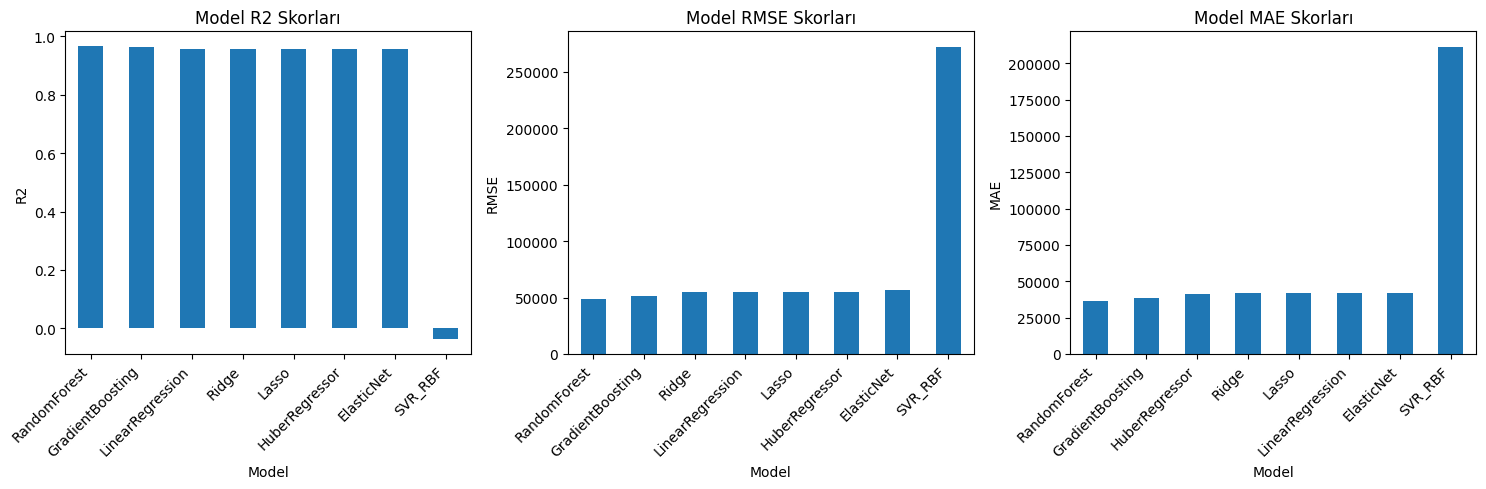

In [7]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, HuberRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.model_selection import cross_validate
import pandas as pd
import numpy as np

#Regresyon Modelleri
models = {
    'LinearRegression' : LinearRegression(),
    'Ridge'            : Ridge(alpha=1.0),
    'Lasso'            : Lasso(alpha=0.1),
    'ElasticNet'       : ElasticNet(alpha=0.1, l1_ratio=0.5),
    'HuberRegressor'   : HuberRegressor(),
    'SVR_RBF'          : SVR(kernel='rbf'),
    'RandomForest'     : RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'GradientBoosting' : GradientBoostingRegressor(n_estimators=100, random_state=42)
}

#Önemli Değerlendirme Metrikleri
scorings = {
    'R2'     : 'r2',
    'MAE'    : 'neg_mean_absolute_error',
    'MSE'    : 'neg_mean_squared_error',
    'RMSE'   : 'neg_root_mean_squared_error',
    'MAPE'   : 'neg_mean_absolute_percentage_error'
}

#10-Kat Çapraz Doğrulama
results = []
for name, model in models.items():
    metrics = {'Model': name}
    try:
        cv_scores = cross_validate(model, X_pca, y, cv=10, scoring=scorings, n_jobs=-1, error_score='raise')
        for metric, score in cv_scores.items():
            if metric.startswith('test_'):
                key = metric.replace('test_', '')
                value = score.mean()
                if 'neg' in scorings.get(key.upper(), ''):
                    value = -value
                metrics[key] = round(value, 4)
    except Exception as e:
        for key in scorings.keys():
            metrics[key] = np.nan
        metrics['Error'] = str(e)
    results.append(metrics)

#Sonuçları Göster
df_eval = pd.DataFrame(results).set_index('Model')
print(df_eval)


#Grafik Çizme 
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
df_mean = df_eval.mean(axis=1).sort_values(ascending=False)
df_mean.plot(kind='bar')
plt.title('Ortalama Model Performansı')
plt.ylabel('Ortalama Değer (Ölçeğe Dikkat!)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#Çubuk Grafikler
metrics_to_plot = ['R2', 'RMSE', 'MAE']
plt.figure(figsize=(15, 5))
for i, metric in enumerate(metrics_to_plot):
    plt.subplot(1, 3, i + 1)
    df_eval[metric].sort_values(ascending=(metric != 'R2')).plot(kind='bar')
    plt.title(f'Model {metric} Skorları')
    plt.ylabel(metric)
    plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

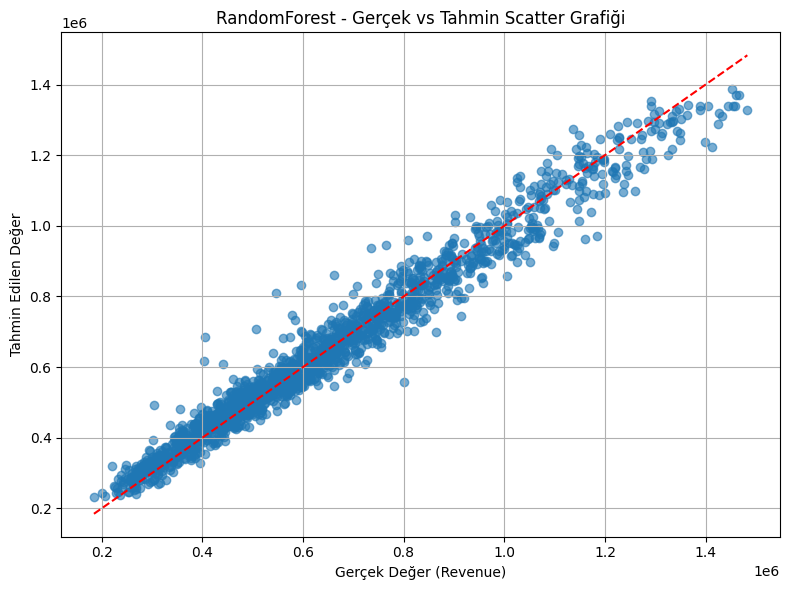

In [9]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd

# En iyi R2 skoru veren model
df_eval = pd.DataFrame(results).set_index('Model')
best_model_name = df_eval['R2'].idxmax()
best_model = models[best_model_name]

# Eğitim–test ayırma (R² skorunu test verisi üzerinden görmek için)
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# Modeli eğit
best_model.fit(X_train, y_train)

# Tahmin yap
y_pred = best_model.predict(X_test)

# Scatter plot çizimi
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # referans çizgisi (mükemmel tahmin)
plt.xlabel("Gerçek Değer (Revenue)")
plt.ylabel("Tahmin Edilen Değer")
plt.title(f'{best_model_name} - Gerçek vs Tahmin Scatter Grafiği')
plt.grid(True)
plt.tight_layout()
plt.show()
